In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import netCDF4 as nc
from scipy.ndimage import binary_dilation

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, espra, smooth, robust_smooth, Rc_finder, tangential_velocity


#### IMOS Data

In [2]:
ssh_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/2Drifter_IMOS_Data.nc'
ssh_dataset = nc.Dataset(ssh_path, mode='r')

lon_ssh, lat_ssh = ssh_dataset['LONGITUDE'][:].data, ssh_dataset['LATITUDE'][:].data
lon_ssh, lat_ssh = np.meshgrid(lon_ssh, lat_ssh)
u_ssh, v_ssh = ssh_dataset['UCUR'][:].data, ssh_dataset['VCUR'][:].data # TIME, LATITUDE, LONGITUDE
u_ssh, v_ssh = np.transpose(u_ssh, axes=(2,1,0)), np.transpose(v_ssh, axes=(2,1,0)) # LON, LAT, TIME
tim_ssh = ssh_dataset['TIME'][:].data # days since 1985-01-01 00:00:00 UTC

ref_date = pd.Timestamp("1985-01-01 00:00:00")
tim_ssh = ref_date + pd.to_timedelta(tim_ssh, unit="D")

dic_ssh_data = {}
for t, time in enumerate(tim_ssh):
    ut, vt = u_ssh[:,:,t].T, v_ssh[:,:,t].T
    ut = np.where(np.abs(ut) < 4.9, ut, np.nan)
    vt = np.where(np.abs(vt) < 4.9, vt, np.nan)
    dic_ssh_data[time] = {'u': ut, 'v': vt}


theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
x_ssh = (lon_ssh - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
y_ssh = (lat_ssh - phi_mean) * 111000


#### Drifter Data

In [3]:
drifter_path = '/srv/scratch/z5297792/IN2023/2Drifter_Data/CCE_2023_6h.nc'
drifter_dataset = nc.Dataset(drifter_path, mode='r')

u_drif, v_drif = drifter_dataset['ve'][:].data/100, drifter_dataset['vn'][:].data/100
lon_drif, lat_drif = drifter_dataset['longitude'][:].data, drifter_dataset['latitude'][:].data
ID_drif =  drifter_dataset['ID'][:]
secs = drifter_dataset['time'][:].data
tim_drif = [datetime.utcfromtimestamp(t).strftime('%Y-%m-%d %H:%M:%S') for t in secs]
df_drifters = pd.DataFrame({'ID': ID_drif.astype(int), 'Lon': lon_drif, 'Lat': lat_drif, 'u': u_drif, 'v': v_drif, 'Time': tim_drif})
df_drifters['Time'] = pd.to_datetime(df_drifters['Time'])
df_drifters = df_drifters[np.hypot(df_drifters.u, df_drifters.v) < 100]
df_drifters = df_drifters.reset_index().drop(columns=['index'])
df_drifters = df_drifters[df_drifters.Time < pd.Timestamp('2024-02-10 00:00:00')]

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
df_drifters['x'] = (df_drifters.Lon - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
df_drifters['y'] = (df_drifters.Lat - phi_mean) * 111000

df_drifters.head()


,ID,Lon,Lat,u,v,Time,x,y
0,300534062034380,153.975,-37.651,0.003961,0.004561,2023-10-19 12:00:00,-28466.208360,27639.0
1,300534062034380,154.095,-37.579,0.004713,0.003265,2023-10-19 18:00:00,-17955.608350,35631.0
2,300534062034380,154.206,-37.523,0.004703,0.001505,2023-10-20 00:00:00,-8233.303341,41847.0
3,300534062034380,154.325,-37.520,0.004957,-0.000603,2023-10-20 06:00:00,2189.708335,42180.0
4,300534062034380,154.448,-37.547,0.004584,-0.001956,2023-10-20 12:00:00,12963.073346,39183.0


In [4]:
start = df_drifters.Time.min() + pd.Timedelta(days=1)
end   = df_drifters.Time.max() - pd.Timedelta(days=1)
times = pd.date_range(start, end, freq='D')

results = []
rho2s, vts, Qrs = [], [], []
dic_drif = {}
for t in times:
    mask = df_drifters.Time.between(t - pd.Timedelta(days=1),
                                     t + pd.Timedelta(days=1))
    
    xi, yi = df_drifters.loc[mask, ['x', 'y']].values.T
    ui, vi = df_drifters.loc[mask, ['u', 'v']].values.T
    dic_drif[t] = pd.DataFrame({'xi': xi, 'yi': yi, 'ui': ui, 'vi': vi, 'ID':df_drifters.loc[mask, 'ID']})
    
    xc, yc, w, Q, Rc, psi0, A = espra(xi, yi, ui, vi, plot_flag=False) 

    results.append(dict(xc=xc, yc=yc, w=w, Q=Q,
                        Rc=Rc, psi0=psi0, A=A, Time=t))

    dx, dy = xi - xc, yi - yc
    rho2s.extend(Q[0,0]*dx**2 + 2*Q[0,1]*dx*dy + Q[1,1]*dy**2)
    Qrs.extend(np.sqrt((Q[0,0]*dx + Q[0,1]*dy)**2 + (Q[0,1]*dx + Q[1,1]*dy)**2))
    vts.extend(np.abs(tangential_velocity(xi, yi, ui, vi, xc, yc, Q)))
df_Rc_data = pd.DataFrame({'vt': vts, 'rho2': rho2s, 'Qr': Qrs})
df_res = pd.DataFrame(results)
df_res


,xc,yc,w,Q,Rc,psi0,A,Time
0,-3294.288090,-5573.143661,-2.697520e-07,"[[1.2635982637637448, -0.10707401260578124], [...",37046.442413,336.317729,-2.450511e-07,2023-10-20 12:00:00
1,1945.672245,-1983.946760,-3.081814e-07,"[[1.3293208151381595, -0.04500609294896531], [...",52944.843643,207.353784,-7.397153e-08,2023-10-21 12:00:00
2,-5712.588384,-4674.576152,-3.081809e-07,"[[1.057938384116587, 0.05131669477175005], [0....",77158.693873,606.295822,-1.018392e-07,2023-10-22 12:00:00
3,-11550.619825,-7158.844558,-3.312418e-07,"[[1.0271745315810092, 0.12584982536503997], [0...",60917.127473,441.425648,-1.189539e-07,2023-10-23 12:00:00
4,-12920.830796,-1271.000642,-3.236959e-07,"[[1.0737560410031401, -0.051220084010595066], ...",50894.230468,334.675467,-1.292072e-07,2023-10-24 12:00:00
...,...,...,...,...,...,...,...,...
107,-316915.391321,79699.292145,-3.631419e-07,"[[1.1809806981213034, -0.24468992797273126], [...",44744.152257,174.897279,-8.735957e-08,2024-02-04 12:00:00
108,-318831.676911,73550.482818,-3.867672e-07,"[[0.9598894244796427, -0.28785697586707953], [...",40725.024524,153.607281,-9.261666e-08,2024-02-05 12:00:00
109,-314499.721790,64718.385930,-3.437281e-07,"[[0.7170437097597633, 0.1903227331436839], [0....",59145.784181,341.868599,-9.772634e-08,2024-02-06 12:00:00
110,-316009.011651,66870.755711,-4.153915e-07,"[[0.6369083577186058, 0.26636756722859073], [0...",67418.486786,484.126732,-1.065126e-07,2024-02-07 12:00:00


(np.float64(-363460.9277624063),
 np.float64(54011.34580137564),
 np.float64(-58152.90000000024),
 np.float64(166266.89999999985))

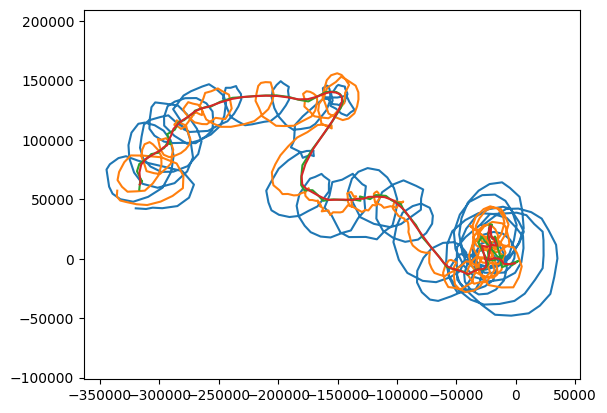

In [5]:
wdw = 3
df_res['sxc'] = smooth(df_res.xc, df_res.Time, window=wdw, num=len(df_res)) 
df_res['syc'] = smooth(df_res.yc, df_res.Time, window=wdw, num=len(df_res)) 

for d in df_drifters.ID.unique():
    df = df_drifters[df_drifters.ID==d]
    plt.plot(df.x, df.y)

plt.plot(df_res.xc, df_res.yc)
plt.plot(df_res.sxc, df_res.syc)
plt.axis('equal')


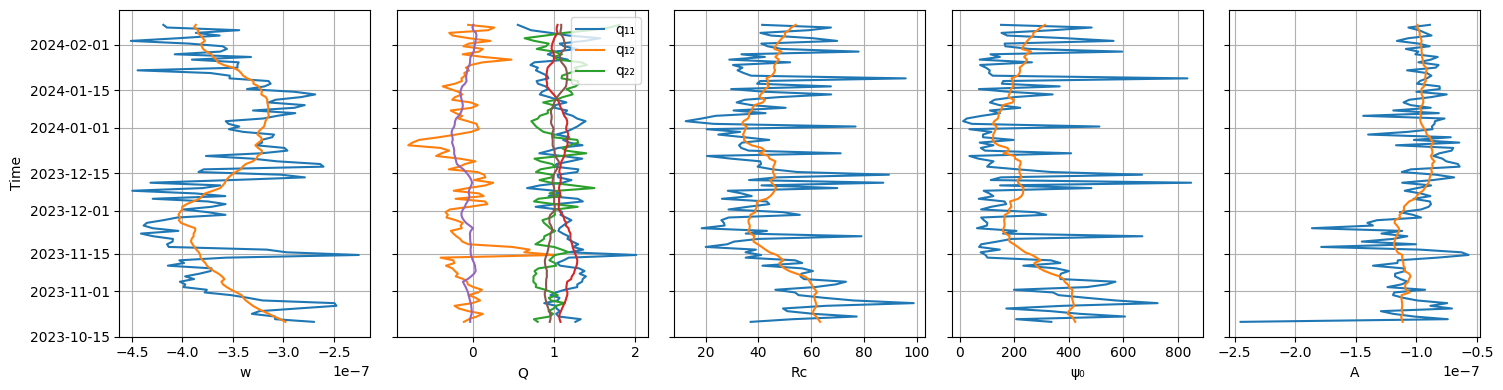

In [6]:
wdw = 20
df_res['sw'] = smooth(df_res.w, df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq11'] = smooth(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq12'] = smooth(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sq22'] = smooth(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, window=wdw, num=len(df_res)) 
df_res['sRc'] = smooth(df_res.Rc, df_res.Time, window=wdw, num=len(df_res)) 
df_res['spsi0'] = smooth(df_res.psi0, df_res.Time, window=wdw, num=len(df_res)) 
df_res['sA'] = smooth(df_res.A, df_res.Time, window=wdw, num=len(df_res)) 

fig, axs = plt.subplots(1, 5, figsize=(15,4), sharey=True)

axs[0].plot(df_res.w, df_res.Time)
axs[0].plot(df_res.sw, df_res.Time)
axs[0].set_xlabel('w')

axs[1].plot(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Time, label='q₁₁')
axs[1].plot(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Time, label='q₁₂')
axs[1].plot(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Time, label='q₂₂')
axs[1].plot(df_res.sq11, df_res.Time)
axs[1].plot(df_res.sq12, df_res.Time)
axs[1].plot(df_res.sq22, df_res.Time)
axs[1].set_xlabel('Q')
axs[1].legend()

axs[2].plot(df_res.Rc/1000, df_res.Time)
axs[2].plot(df_res.sRc/1000, df_res.Time)
axs[2].set_xlabel('Rc')

axs[3].plot(df_res.psi0, df_res.Time)
axs[3].plot(df_res.spsi0, df_res.Time)
axs[3].set_xlabel('ψ₀')

axs[4].plot(df_res.A, df_res.Time)
axs[4].plot(df_res.sA, df_res.Time)
axs[4].set_xlabel('A')

for ax in axs:
    ax.grid(True)
axs[0].set_ylabel('Time')

plt.tight_layout()


A_opt = 0.0000, Rc_opt = 76838.7081, psi0_opt = -548.4444


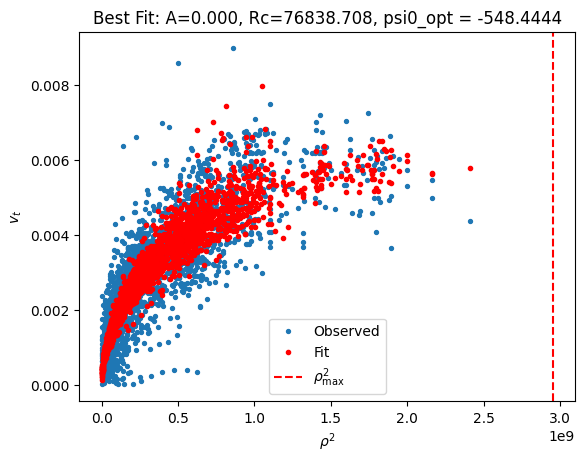

In [7]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

rho2 = df_Rc_data.rho2.values
vt = df_Rc_data.vt.values
Qr = df_Rc_data.Qr.values

def vt_theo_func(rho2, A, Rc):
    return 2 * np.abs(A) * np.exp(-rho2 / Rc**2) * Qr

# initial guess from your Rc_0 estimate
idx_max_vt = np.argmax(vt)
rho_max = np.sqrt(rho2[idx_max_vt]) if rho2[idx_max_vt] >= 0 else np.nan
Rc_0 = rho_max * np.sqrt(2)
A_0 = np.nanmax(vt) / (2 * np.nanmax(Qr))  # rough initial guess letting rho=0

popt, pcov = curve_fit(vt_theo_func, rho2, vt, p0=[A_0, Rc_0], maxfev=10000)
A_opt, Rc_opt = popt
psi0_opt = - A_opt * Rc_opt**2

print(f"A_opt = {A_opt:.4f}, Rc_opt = {Rc_opt:.4f}, psi0_opt = {psi0_opt:.4f}")

vt_fit = vt_theo_func(rho2, *popt)

plt.scatter(rho2, vt, s=8, label='Observed')
plt.scatter(rho2, vt_fit, color='r', label='Fit', marker='.')
plt.axvline(x=Rc_opt**2/2, color='r', ls='--', label=r'$\rho_\max^2$')
plt.xlabel(r'$\rho^2$')
plt.ylabel(r'$v_t$')
plt.legend()
plt.title(f'Best Fit: A={A_opt:.3f}, Rc={Rc_opt:.3f}, psi0_opt = {psi0_opt:.4f}')
plt.show()


Text(0, 0.5, 'y (km)')

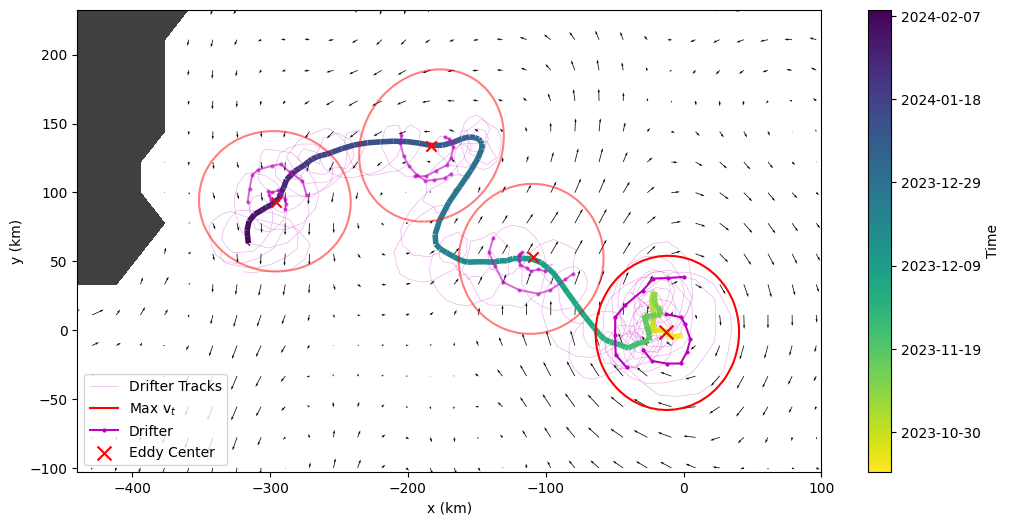

In [8]:
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates

x = np.linspace(-450000, 150000, 101)
y = np.linspace(-100000, 250000, 101)
X, Y = np.meshgrid(x, y, indexing='ij')

k = 4
data = df_res.iloc[k]

closest = min(tim_ssh, key=lambda tt: abs(tt - data.Time))
ut, vt = dic_ssh_data[closest]['u'], dic_ssh_data[closest]['v']
mask = (x_ssh/1e3>=-450)&(x_ssh/1e3<=150)&(y_ssh/1e3>=-100)&(y_ssh/1e3<=250)
ut, vt = np.where(mask, ut, np.nan), np.where(mask, vt, np.nan)

fig, ax = plt.subplots(figsize=(12,6))
plt.quiver(x_ssh/1e3, y_ssh/1e3, ut, vt, width=.001, scale=30)
for dd, d in enumerate(df_drifters.ID.unique()):
    df = df_drifters[df_drifters.ID==d]
    plt.plot(df.x/1e3, df.y/1e3, lw=.5, alpha=.3, color='m',
             label='Drifter Tracks'if dd==0 else'')
# plt.plot(df_res.sxc/1e3, df_res.syc/1e3) 
x,y,t=df_res.sxc/1e3,df_res.syc/1e3,df_res.Time
t_num=mdates.date2num(t)
pts=np.array([x,y]).T.reshape(-1,1,2)
segs=np.concatenate([pts[:-1],pts[1:]],1)
lc=LineCollection(segs,cmap='viridis_r',norm=plt.Normalize(t_num.min(),t_num.max()),lw=4)
lc.set_array(t_num)
ax.add_collection(lc)
cb=fig.colorbar(lc,ax=ax)
cb.ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
cb.set_label('Time')

# Main Timeframe
dx_ell, dy_ell = X/1e3 - data.sxc/1e3, Y/1e3 - data.syc/1e3
rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
plt.contour(X/1e3, Y/1e3, rho2_ell, levels=[(Rc_opt/1e3)**2/2],
            colors='r', zorder=3, linewidths=1.5)
plt.plot([], [], color='r', lw=1.5, label=r'Max v$_t$') 
df = dic_drif[data.Time]
for dd, d in enumerate(df.ID.unique()):
    df_d = df[df.ID==d]
    plt.plot(df_d.xi/1e3, df_d.yi/1e3, marker='.', color='m',
             markersize=4, label='Drifter'if dd==0 else'')
plt.scatter(data.xc/1e3, data.yc/1e3, marker='x', color='r',
            s=100, zorder=5, label='Eddy Center')

# Other Timeframes
alpha = .5
for t_idx in [51, 80, 102]:
    
    data = df_res.iloc[t_idx]
    dx_ell, dy_ell = X/1e3 - data.sxc/1e3, Y/1e3 - data.syc/1e3
    rho2_ell = data.sq11*dx_ell**2 + 2*data.sq12*dx_ell*dy_ell + data.sq22*dy_ell**2
    plt.contour(X/1e3, Y/1e3, rho2_ell, levels=[(Rc_opt/1e3)**2/2],
                colors='r', zorder=3, alpha=alpha)
    df = dic_drif[data.Time]
    for d in df.ID.unique():
        df_d = df[df.ID==d]
        plt.plot(df_d.xi/1e3, df_d.yi/1e3, marker='.', color='m',
                 markersize=4, alpha=alpha)
    plt.scatter(data.xc/1e3, data.yc/1e3, marker='x', color='r', s=55, zorder=5)

mask_nan = np.isnan(ut)
land_mask = np.where(mask_nan & mask, 0, np.nan)
plt.contourf(x_ssh/1e3, y_ssh/1e3, land_mask, cmap='grey')

plt.axis('equal'); plt.legend(loc='lower left')
plt.xlim(-440, 100); plt.ylim(-100, 230)
plt.xlabel('x (km)'); plt.ylabel('y (km)')
